<a href="https://colab.research.google.com/github/Horacelhl/Medical-Image-Analysis-IPython-Tutorials/blob/master/11D_BERT_SentimentAnalysis_MovieReview_NLPwGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# import dataset from google drive
from google.colab import drive
drive.mount('/content/drive')
copied_path = "/content/drive/My Drive/IMDB Dataset.csv" #remove ‘content/’ from path then use 
df = pd.read_csv(copied_path)
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Data preprocessing

In [3]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.drop_duplicates(subset=['review'], keep='first',inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49582 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [6]:
# Remove Stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re,string,unicodedata

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [8]:
# Noise Removal

# Extracting all the text only
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
    
# Apply function on review column
df['review']= df['review'].apply(denoise_text)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


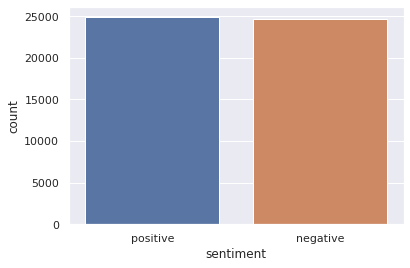

In [9]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(df.sentiment)

# Word Cloud

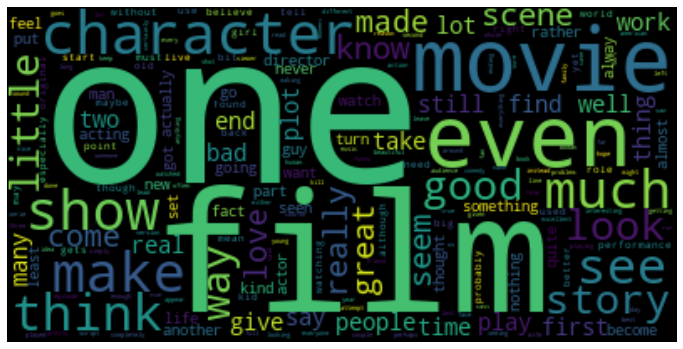

In [10]:
from wordcloud import WordCloud

text = " ".join([x for x in df.review])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

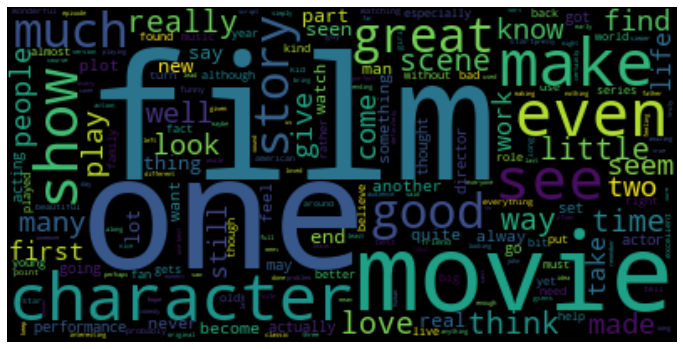

In [11]:
# positive
text = " ".join([x for x in df.review[df.sentiment=='positive']])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

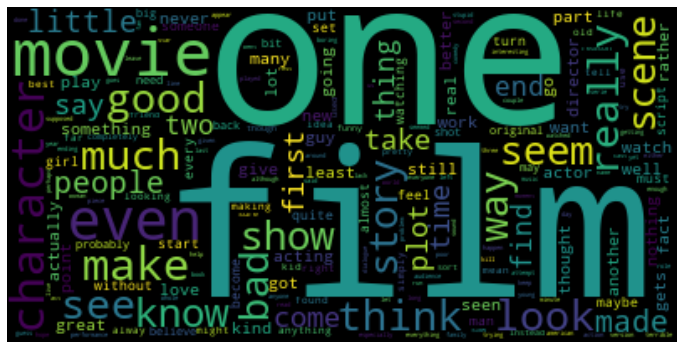

In [12]:
# negative
text = " ".join([x for x in df.review[df.sentiment=='negative']])
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [13]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:10]

['one',
 'reviewers',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'exactly',
 'happened',
 'first',
 'thing']

In [14]:
# most comment words top 20

from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(20)
most_common = dict(most_common)
most_common

{'also': 15666,
 'could': 14789,
 'even': 23525,
 'film': 54702,
 'first': 15343,
 'get': 17555,
 'good': 23305,
 'great': 15366,
 'like': 36994,
 'made': 13432,
 'make': 14921,
 'movie': 61015,
 'much': 17142,
 'one': 44730,
 'people': 14903,
 'really': 21647,
 'see': 20715,
 'story': 16701,
 'time': 15534,
 'would': 23618}

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
import plotly.express as px
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [17]:
df['sentiment'].value_counts()

positive    24884
negative    24698
Name: sentiment, dtype: int64

# Splitting training and test data

In [18]:
train,eva = train_test_split(df,test_size = 0.2)

In [19]:
pip install simpletransformers

In [20]:
from simpletransformers.classification import ClassificationModel

# Create a Transformer Model


model = ClassificationModel('bert',
                            'bert-base-cased',
                            args={'reprocess_input_data': True,
                                  'overwrite_output_dir': True})

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification

# Convert label to 0,1

In [21]:
# 0,1: positive,negative
def making_label(st):
    if(st=='positive'):
        return 0    
    else:
        return 1
    
train['label'] = train['sentiment'].apply(making_label)
eva['label'] = eva['sentiment'].apply(making_label)
print(train.shape)

(39665, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
train_df = pd.DataFrame({
    'text': train['review'][:4000].replace(r'\n', ' ', regex=True),
    'label': train['label'][:4000]
})

eval_df = pd.DataFrame({
    'text': eva['review'][-1000:].replace(r'\n', ' ', regex=True),
    'label': eva['label'][-1000:]
})

# Training a Classification Model

In [23]:
model.train_model(train_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:377: UserWarning:

Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning:

Please also save or load the state of the optimizer when saving or loading the scheduler.



(500, 0.5036281682699919)

# Evaluating a Classification Model

In [24]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:896: UserWarning:

Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.



In [25]:
result

{'eval_loss': 0.41864357540011404,
 'fn': 104,
 'fp': 74,
 'mcc': 0.6452034346315393,
 'tn': 425,
 'tp': 397}

In [26]:
model_outputs

array([[-0.57763672, -0.40136719],
       [-1.17578125,  0.47021484],
       [-0.15600586, -0.75244141],
       ...,
       [-1.60546875,  0.52197266],
       [ 0.54833984, -1.21191406],
       [-1.81933594,  1.02050781]])

In [27]:
lst = []
for arr in model_outputs:
    lst.append(np.argmax(arr))

In [28]:
true = eval_df['label'].tolist()
predicted = lst

In [29]:
import sklearn
cm = sklearn.metrics.confusion_matrix(true , predicted)
cm

array([[425,  74],
       [104, 397]])

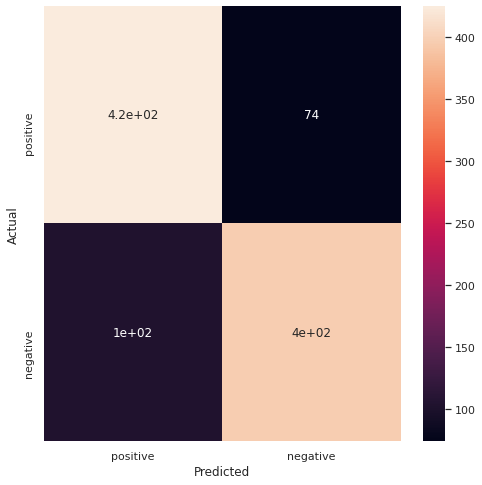

In [30]:
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot=True, xticklabels = ['positive','negative'] , yticklabels = ['positive','negative']) 
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [31]:
print(sklearn.metrics.classification_report(true,predicted,target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.80      0.85      0.83       499
    negative       0.84      0.79      0.82       501

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000



In [32]:
sklearn.metrics.accuracy_score(true,predicted)

0.822

# Making Predictions With a Classification Model

In [33]:
def get_result(statement):
    result = model.predict([statement])
    pos = np.where(result[1][0] == np.amax(result[1][0]))
    pos = int(pos[0])
    sentiment_dict = {0:'positive',1:'negative'}
    print(sentiment_dict[pos])
    return

In [34]:
get_result("I'm upset that zero stars is not an option. If George Lucas were already passed, he'd be spinning in his grave, so I can't even imagine the living equivalent.")


negative


In [41]:
get_result("I am happy")


positive


In [39]:
get_result("bad story")


negative
